In [1]:
from collections import defaultdict, Counter
import os, itertools, copy, datetime, importlib, logging, pickle
from tqdm.auto import tqdm
from pathlib import Path
from util import config_logger

import numpy as np
import pandas as pd
from umap import UMAP
from anndata import AnnData
import scanpy as sc

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

import doubletdetection

logger = config_logger(logging.getLogger(__name__))

/opt/conda/envs/3Dgenome/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def reload_all():
    import doubletdetection, backend
    importlib.reload(doubletdetection)
    importlib.reload(backend)

reload_all()

In [3]:
%%time
reload_all()
from backend import Library

path2root = Path('/home/xinyuelu/AD-proj/results/')
path2resdir = Path(f'{path2root}/results-annotate-hPFC/')

lib, species = 'hPFC-lib-all', 'hg38'
walk_policy = 'complete'
res, res_str = int(5e5), '500kb'

suffix = f'{lib}_human_hg38'
obj = Library('none', 'none', lib, path2root, wellid_list=path2root / 'results' / lib / f'meta_{suffix}.pkl')
obj.load_RNA(path2root / 'results' / lib / f'RNA_{suffix}.pkl')
# obj.load_DNA(path2root / 'results' / 'merged_data' / suffix / f'contact_{res_str}.pkl')
obj.load_meta(path2root / 'results' / lib / f'meta_{suffix}.csv')

2025-01-22 04:46:44:INFO:Loading /home/xinyuelu/AD-proj/results/results/hPFC-lib-all/meta_hPFC-lib-all_human_hg38.pkl
2025-01-22 04:46:44:INFO:# of cells: 30557
2025-01-22 04:46:44:INFO:Loading /home/xinyuelu/AD-proj/results/results/hPFC-lib-all/RNA_hPFC-lib-all_human_hg38.pkl
2025-01-22 04:46:48:INFO:Loaded 58408 genes, 85472822 cell-gene, and 871116514 mRNAs
2025-01-22 04:46:48:INFO:Loading /home/xinyuelu/AD-proj/results/results/hPFC-lib-all/meta_hPFC-lib-all_human_hg38.csv


CPU times: user 1.02 s, sys: 1.24 s, total: 2.26 s
Wall time: 4.71 s


In [4]:
adata = AnnData(np.asarray(obj.gene_expr.todense()), obs=obj.meta, var=obj.gene_i2a)
sc.pp.filter_genes(adata, min_cells=10)
raw_expr = adata.X.copy()

FileNotFoundError: [Errno 2] No such file or directory: '/home/xinyuelu/AD-proj/results/results-annotate-hPFC/UMAP_RNA-Seurat-wd_hPFC-lib-all_complete_hg38_filtered.csv'

In [5]:
df = pd.read_csv(path2resdir / f'UMAP_RNA-Seurat-wd_{lib}-raw.csv', index_col=0)
adata.obsm['X_umap'] = df.loc[adata.obs.index].values
df = pd.read_csv(path2resdir / f'meta-Seurat-wd_{lib}-raw.csv', index_col=0).iloc[:, 0]
df = df.loc[adata.obs.index,]
adata.obs['cell type'] = pd.Categorical(pd.Series(df.values, index=adata.obs.index), categories=np.unique(df))

In [6]:
n_cluster = len(np.unique(adata.obs['cell type']))
print(n_cluster)

33


In [7]:
np.random.seed(0)
clf = doubletdetection.BoostClassifier(
    n_iters=100,
    n_components=n_cluster,
    clustering_algorithm="louvain", 
    standard_scaling=True,
    pseudocount=1,
    n_jobs=64,
).fit(raw_expr)
adata.obs["doublet_score"] = clf.doublet_score()

100%|██████████| 100/100 [31:47<00:00, 19.07s/it]


In [8]:
pd.DataFrame(adata.obs["doublet_score"]).to_csv("doublet_score.csv")

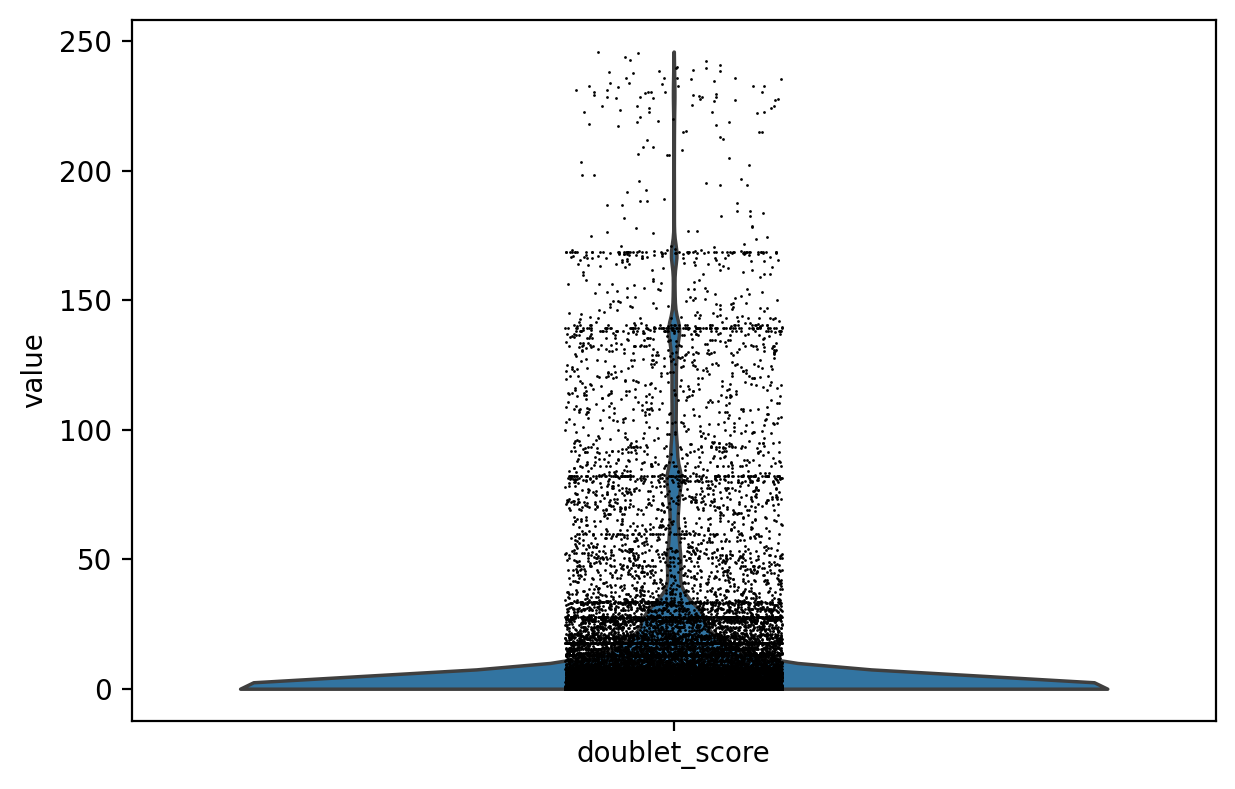

<Figure size 640x480 with 0 Axes>

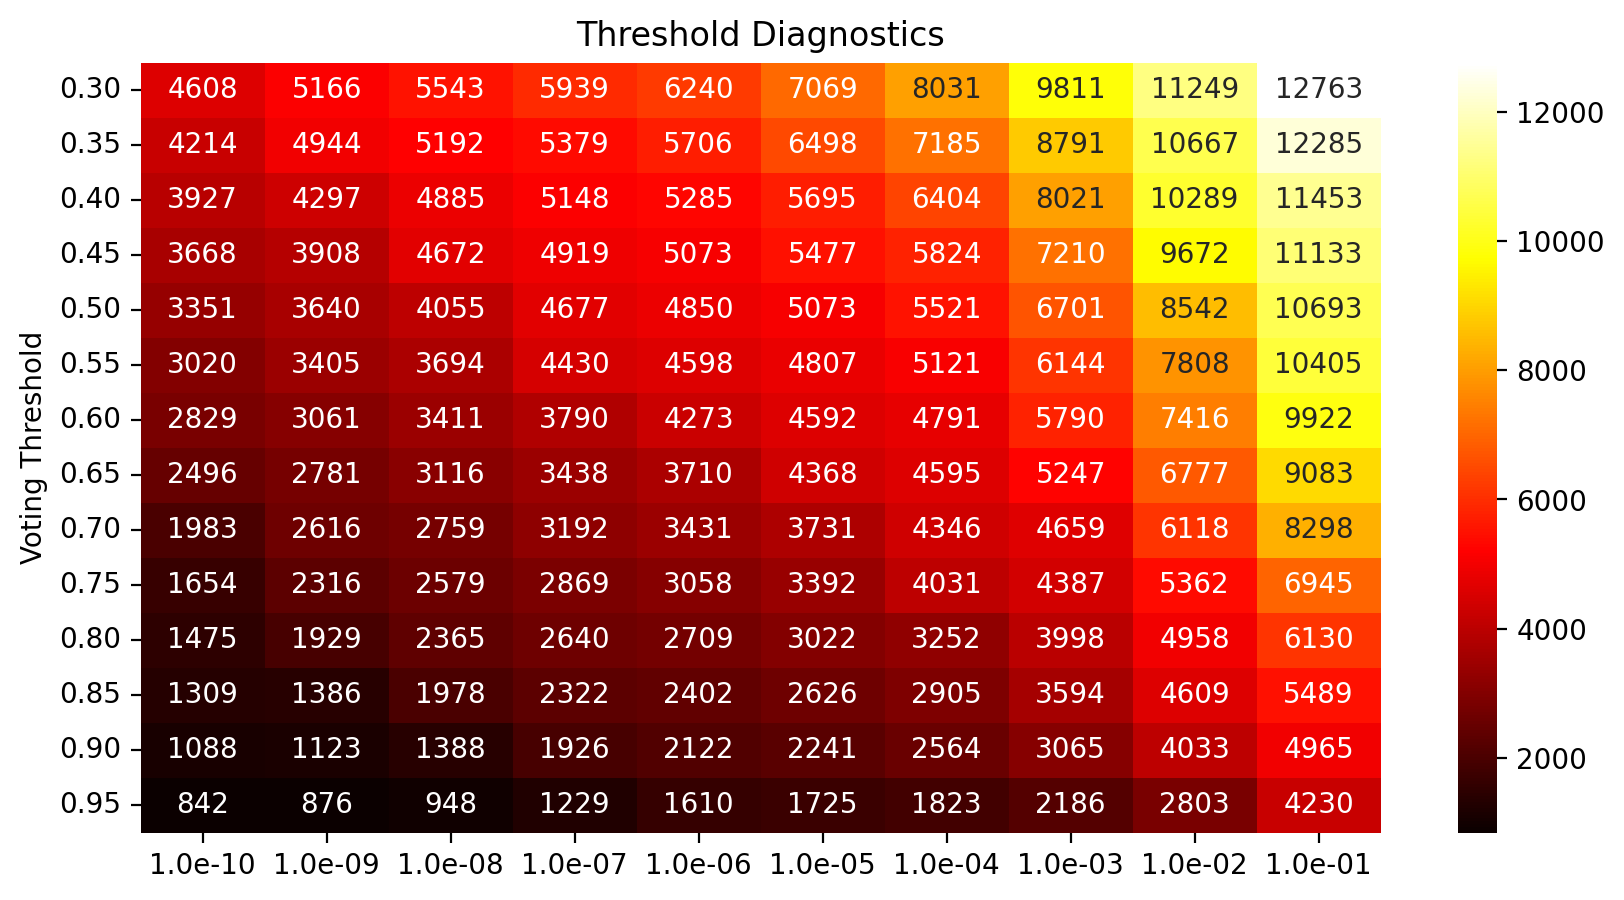

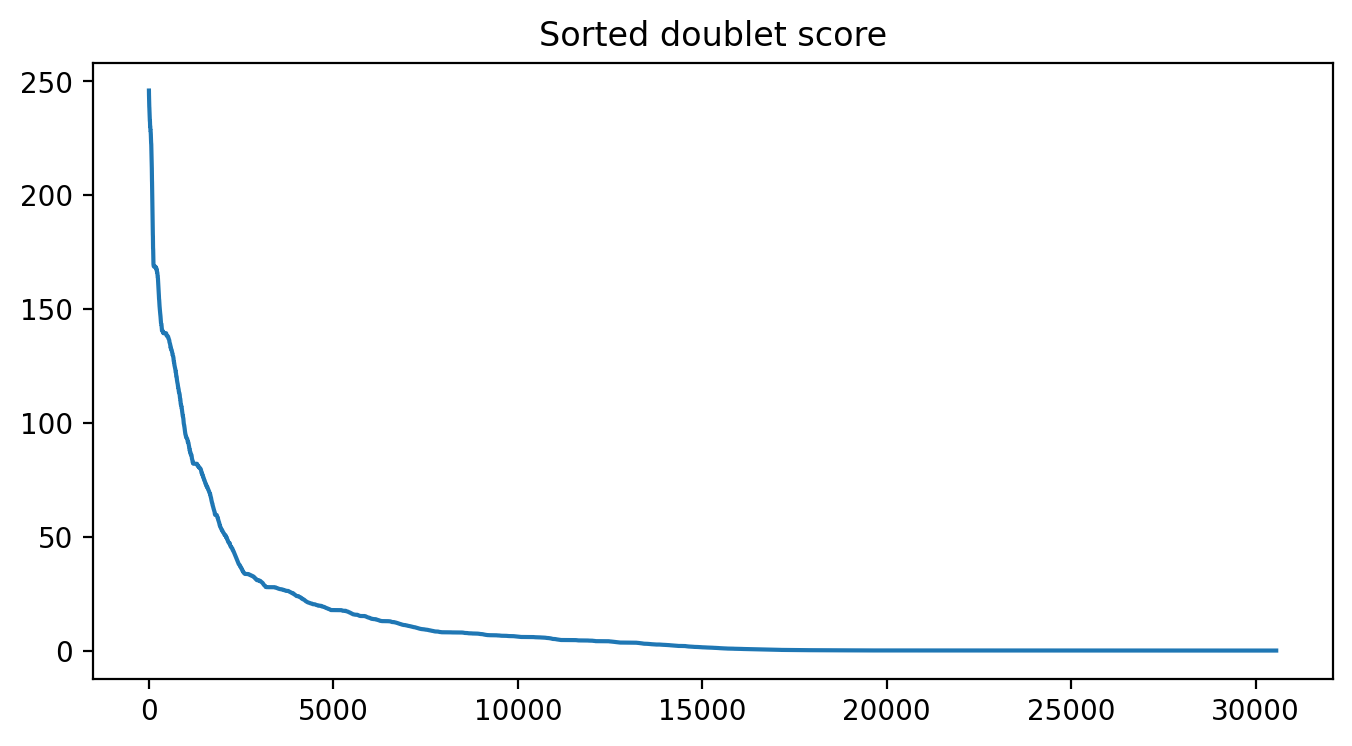

In [9]:
reload_all()
from doubletdetection import plot_overall_stats
plot_overall_stats(adata, clf, path2resdir)

/home/xinyuelu/AD-proj/scripts_results/annotate_cells/doubletdetection.py:639: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby('cell type').sum()
/home/xinyuelu/AD-proj/scripts_results/annotate_cells/doubletdetection.py:640: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = df.div(adata.obs.groupby('cell type').size(), axis=0)


/home/xinyuelu/AD-proj/results/results-annotate-hPFC/doublet_hPFC-lib-all_complete_hg38_filtered.csv
/home/xinyuelu/AD-proj/results/results-annotate-hPFC/doublet_hPFC-lib-all_complete_hg38_filtered.pkl


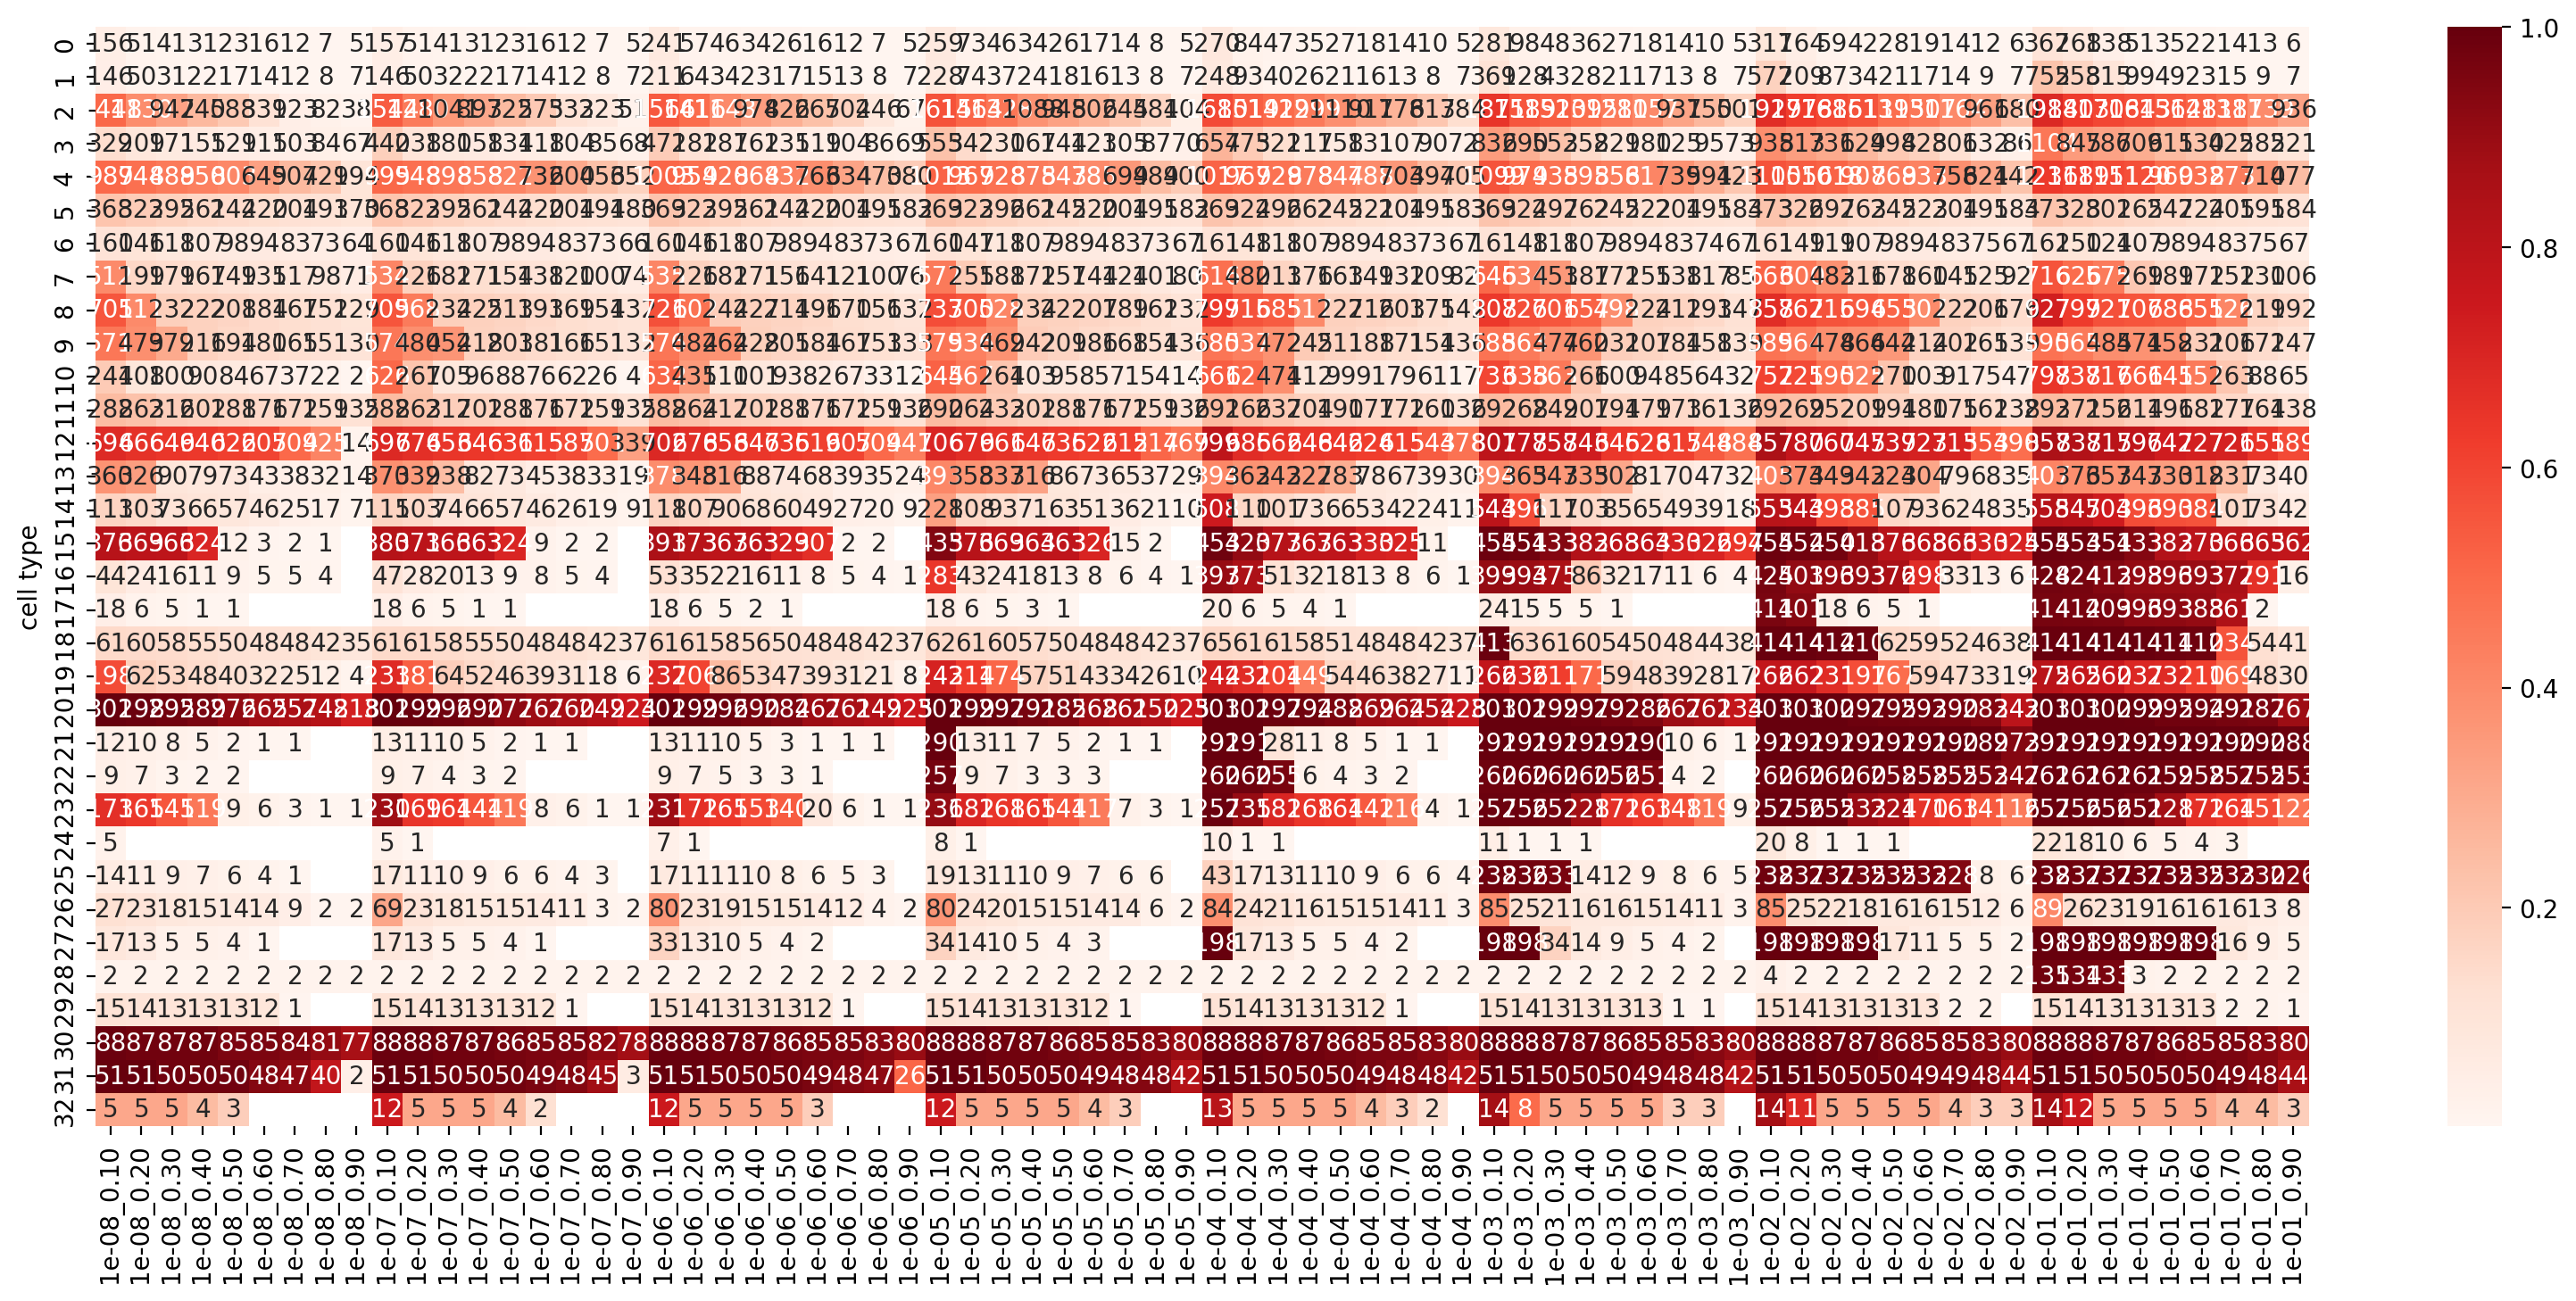

In [10]:
reload_all()
from doubletdetection import save_results
save_results(path2resdir, lib, adata, clf)

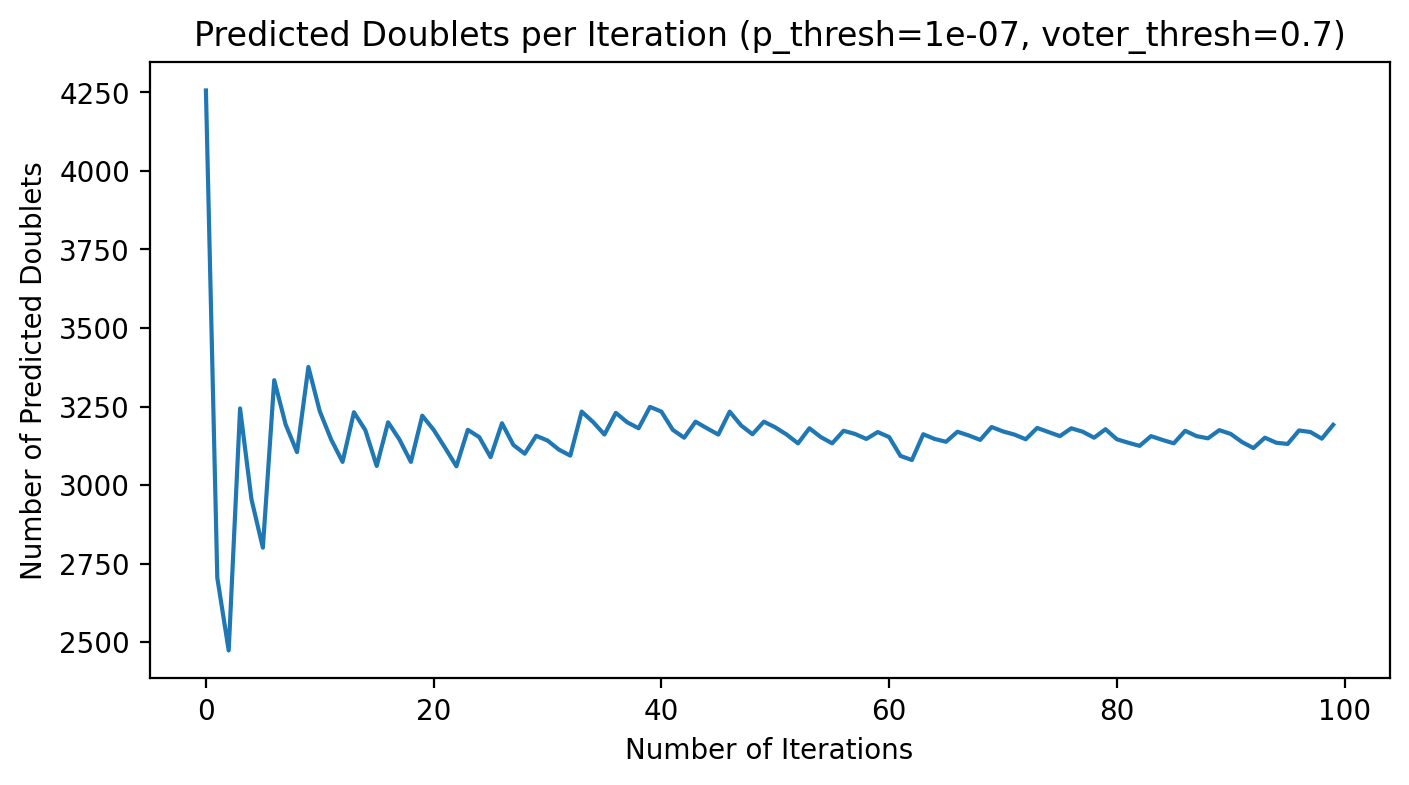

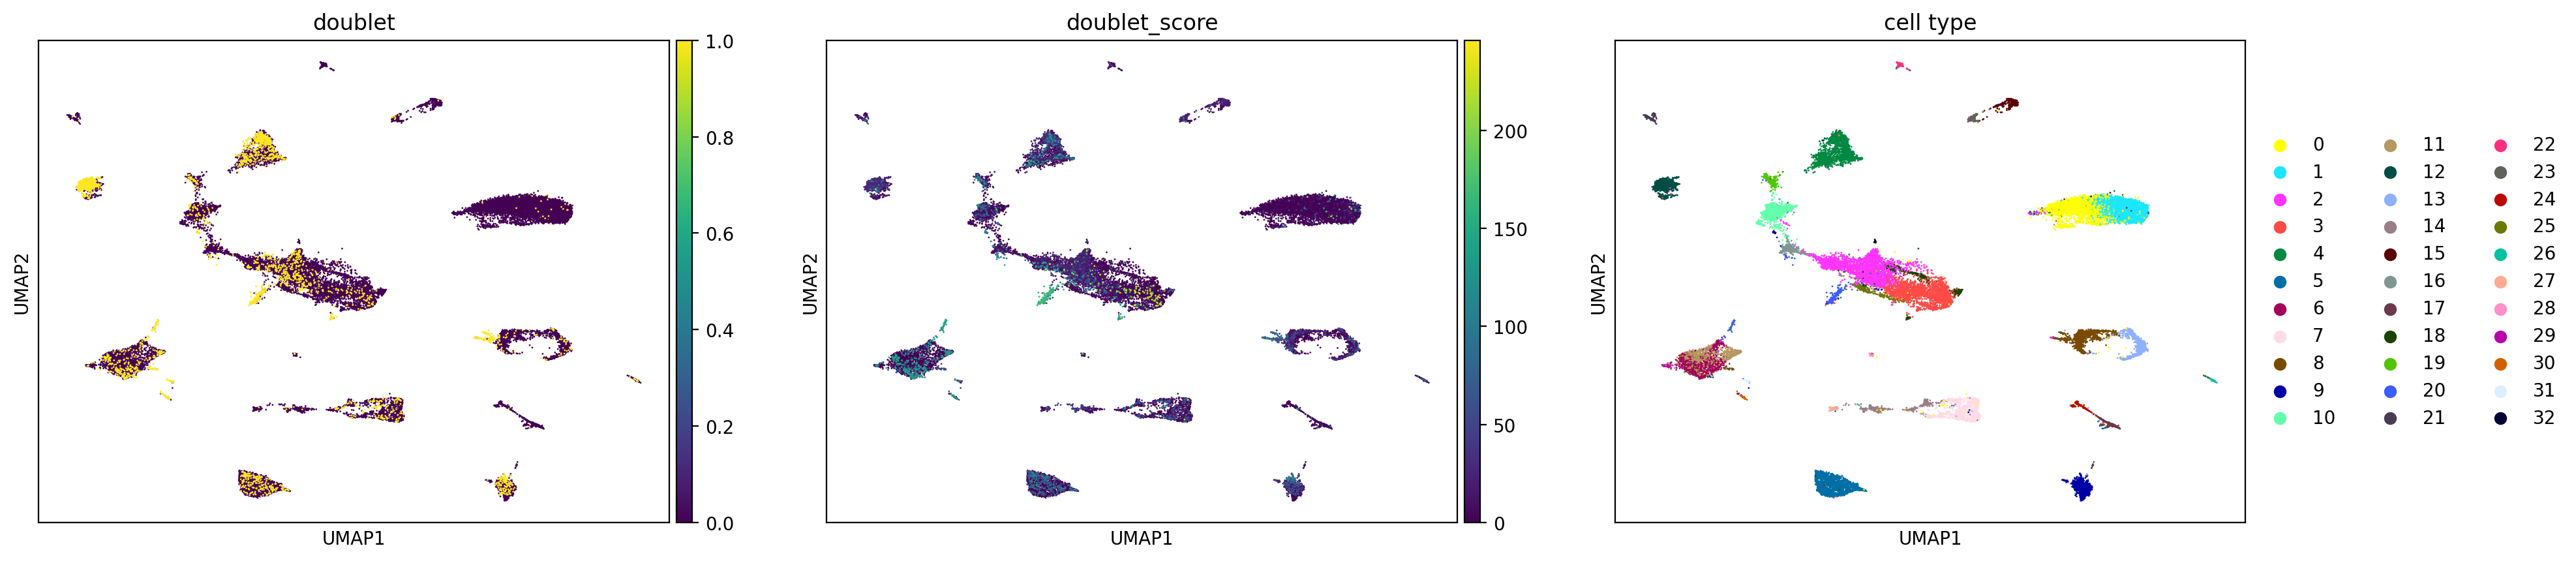

In [15]:
reload_all()
from doubletdetection import test_criterion
p_thr=1e-7
v_thr=.7
test_criterion(adata, clf, p_thr=p_thr, v_thr=v_thr, path2res=path2resdir, lib=lib)